In [4]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 57.3 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from xgboost import XGBClassifier

import re
import string
import spacy

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

In [6]:
# Lectura archivo training
path_train = "./Training_data/Training_data.csv"
df_train = pd.read_csv(path_train, encoding='latin-1', header=None)
df_train.columns = ['polarity','id','date','query','user','text']

# df_neg = df_train[df_train["polarity"] == 0]
# df_pos = df_train[df_train["polarity"] == 4]

# # Samplear 100k de cada clase - Solo para el desarrollo
# df_neg_sample = df_neg.sample(100000, random_state=42,replace=True)
# df_pos_sample = df_pos.sample(100000, random_state=42,replace=True)
# df_train = pd.concat([df_neg_sample, df_pos_sample]).sample(frac=1, random_state=42)

# Lectura archivo test
path_validation = "./Training_data/Test_data_manual.csv"
df_test = pd.read_csv(path_validation, encoding='latin-1', header=None)
df_test.columns = ['polarity','id','date','query','user','text']

print('Shape:', df_train.shape)
df_train.head()

Shape: (1600000, 6)


,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Limpieza y preprocesamiento de texto

In [7]:
# Función para parsear la fecha
def parse_date(s):
    if not isinstance(s, str):
        return pd.NaT
    
    s_clean = re.sub(r'\b[A-Z]{2,4}\b', '', s).strip()
    
    try:
        dt = pd.to_datetime(s_clean, errors='coerce')
        return dt
    except:
        return pd.NaT

df_train['date_parsed'] = df_train['date'].apply(parse_date)
df_test['date_parsed']  = df_test['date'].apply(parse_date)

# Aplico limpieza de datos para quitar urls, menciones a otros usuarios, hashtags, números, puntuaciones y múltiples espacios.
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    return  ' '.join([token.lemma_ for token in doc if not token.is_stop])
    
nlp = spacy.load("en_core_web_sm")
df_train['text_clean'] = df_train['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

df_train.head(2)

,polarity,id,date,query,user,text,date_parsed,text_clean
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06 22:19:45,awww s bummer shoulda get david carr day d
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,upset not update facebook texte cry result sch...


In [ ]:
df_train_copy = df_train.copy()
df_train = df_train[['text_clean', 'polarity']]
X = df_train['text_clean']  
y = df_train['polarity'] 

In [9]:
y.value_counts(normalize=True)*100

polarity
0    50.0
4    50.0
Name: proportion, dtype: float64

### Conclusiones:
Se realizó una limpieza de datos para evitar tener ruido en el texto y evitar generar tokens que no sean relevantes, se creó una nueva columna "text_clean" con esta limpieza y lo mismo para la columna "date" creando la columna "date_parsed" para mantener una fecha más simple y amigable.

Se realizó un diagrama de distribución para visualizar el balanceo de polarity.

Se observa una distribución equilibrada entre comentarios negativos y positivos.

## EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   text_clean  1600000 non-null  object
 1   polarity    1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


None

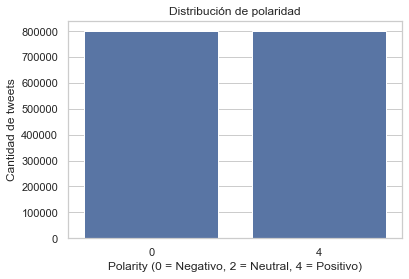

In [10]:
display(df_train.info())

#Diagrama de distribución de polarity
sns.countplot(x=df_train['polarity'])
plt.title("Distribución de polaridad")
plt.xlabel("Polarity (0 = Negativo, 2 = Neutral, 4 = Positivo)")
plt.ylabel("Cantidad de tweets")
plt.show()

## Representación vectorial
### TF-IDF

In [ ]:
tf_idf = TfidfVectorizer(
    max_features=100000, 
    ngram_range=(1, 2), 
    min_df=5,
    stop_words='english'            
)

X_train_tfidf = tf_idf.fit_transform(df_train['text_clean'])

In [12]:
import numpy as np

def top_tfidf_words_per_class(vectorizer, X, y, label, n=15):
    """
    Obtiene los top-n términos TF-IDF más importantes para una clase específica.
    
    vectorizer : TfidfVectorizer ya entrenado
    X          : Serie de textos originales (X_train)
    y          : Serie de labels (0/4)
    """

    corpus = X[y == label]    
    X_tfidf = vectorizer.transform(corpus)
    tfidf_means = np.asarray(X_tfidf.mean(axis=0)).ravel()
    terms = vectorizer.get_feature_names_out()
    top_idx = tfidf_means.argsort()[::-1][:n]
    top_terms = [(terms[i], tfidf_means[i]) for i in top_idx]

    return pd.DataFrame(top_terms, columns=["Término", "Importancia_TFIDF"])

df_top_words = df_train.sample(n=100000, random_state=42)
print("\n🔹 Top 15 palabras para clase 0 (Negativo)")
top_neg = top_tfidf_words_per_class(tf_idf, df_top_words['text_clean'], df_top_words['polarity'], label=0, n=15)
print(top_neg)

print("\n🔹 Top 15 palabras para clase 4 (Positivo)")
top_pos = top_tfidf_words_per_class(tf_idf, df_top_words['text_clean'], df_top_words['polarity'], label=4, n=15)
print(top_pos)



🔹 Top 15 palabras para clase 0 (Negativo)
   Término  Importancia_TFIDF
0     work           0.014601
1     miss           0.014102
2     want           0.010709
3      day           0.010473
4     feel           0.010054
5     like           0.009070
6    today           0.008445
7      sad           0.008403
8     wish           0.008356
9    think           0.007794
10    know           0.007514
11     bad           0.007362
12   sorry           0.007028
13    time           0.007005
14    good           0.006828

🔹 Top 15 palabras para clase 4 (Positivo)
    Término  Importancia_TFIDF
0     thank           0.017756
1      good           0.016910
2      love           0.013539
3       day           0.010949
4       lol           0.008826
5      like           0.008701
6      time           0.007708
7      know           0.007646
8     today           0.006811
9     great           0.006777
10      new           0.006671
11  morning           0.006589
12     work           0.006565


### Conclusión:

Para los datos ya limpios y libre de caracteres especiales se utilizó "TF-IDF" para determinar frecuencia de aparición de palabras y de esta forma qudarme con aquellas palabras que sean más representativas. En este caso se usó N-Gramas de 1 y 2 para analizar expresiones que pueden no considerarse o ser representativas de forma individual.

Se realizó un top 15 para las clases de Negativos y Positivos, para el primer caso se observa que palabras como "miss" o "work" son más frecuentes y para el caso de Positivos tenemos palabras como "good" o "thank".

## Regresión logística

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, y_train.shape

((1120000, 100000), (1120000,))

In [20]:
# Aplico el modelo de regresión logística
mod_reg_log = LogisticRegression(random_state=1, max_iter=1000)
mod_reg_log.fit(X_train, y_train)

y_pred_train = mod_reg_log.predict(X_train)
print("Train report:")
print(classification_report(y_train, y_pred_train))
print("------------------------------------------------------")
y_pred_test = mod_reg_log.predict(X_test)
print("Test report:")
print(classification_report(y_test, y_pred_test))

Train report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78    560000
           4       0.77      0.81      0.79    560000

    accuracy                           0.79   1120000
   macro avg       0.79      0.79      0.79   1120000
weighted avg       0.79      0.79      0.79   1120000

------------------------------------------------------
Test report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76    240000
           4       0.76      0.80      0.78    240000

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



### Conclusión

El modelo de Regresión Logística mostró un rendimiento estable y consistente tanto en entrenamiento como en prueba, indicando una buena capacidad de generalización. En el conjunto de entrenamiento obtuvo una accuracy del 79%, mientras que en el conjunto de prueba alcanzó un 77%, lo que representa una caída esperable.

En cuanto al comportamiento por clase:

* Clase 0 (Negativo):
Presenta una mayor precisión en ambas particiones, lo cual indica que el modelo es relativamente conservador al identificar tweets negativos (cuando predice negativo, suele acertar). Sin embargo, su recall es ligeramente menor, lo que implica que deja pasar algunos negativos reales clasificándolos como positivos.

* Clase 4 (Positivo):
Exhibe un patrón opuesto: mayor recall y ligeramente menor precisión. El modelo identifica correctamente la mayoría de los tweets positivos, aunque comete algunos falsos positivos al confundir tweets negativos como positivos.

El balance entre ambas clases es adecuado, con f1-scores muy cercanos (≈0.76–0.79), lo cual confirma que el modelo está capturando patrones relevantes del lenguaje en ambas polaridades sin un sesgo fuerte hacia ninguna clase.

En términos generales, el modelo:

* Logra un rendimiento competitivo para una tarea clásica de análisis de sentimiento basada en tweets.

* Se beneficia del uso de TF-IDF y n-gramas, lo que mejora su capacidad para identificar expresiones contextuales típicas del lenguaje en redes sociales.

* Mantiene un comportamiento coherente entre train y test, lo que indica un ajuste apropiado al conjunto de datos.

## Naive Bayes

In [21]:
# Aplico el modelo de regresión logística
mod_naive_bayes = MultinomialNB()
mod_naive_bayes.fit(X_train, y_train)

y_pred_train_nb = mod_naive_bayes.predict(X_train)
print("Train report:")
print(classification_report(y_train, y_pred_train_nb))
print("------------------------------------------------------")
y_pred_test_nb = mod_naive_bayes.predict(X_test)
print("Test report:")
print(classification_report(y_test, y_pred_test_nb))

Train report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78    560000
           4       0.78      0.78      0.78    560000

    accuracy                           0.78   1120000
   macro avg       0.78      0.78      0.78   1120000
weighted avg       0.78      0.78      0.78   1120000

------------------------------------------------------
Test report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76    240000
           4       0.76      0.76      0.76    240000

    accuracy                           0.76    480000
   macro avg       0.76      0.76      0.76    480000
weighted avg       0.76      0.76      0.76    480000



### Conclusión

El modelo de Multinomial Naive Bayes mostró un rendimiento sólido y estable para la clasificación de sentimientos en tweets. Con una accuracy del 78% en entrenamiento y un 76% en la evaluación sobre datos de prueba, se observa una diferencia mínima entre ambos conjuntos, lo cual indica que el modelo generaliza bien y no presenta signos significativos de sobreajuste.

El comportamiento por clase es notablemente equilibrado:

* Clase 0 (Negativo):
Tiene valores de precisión, recall y F1 muy cercanos entre sí (≈0.75–0.78), lo que sugiere que el modelo identifica de forma uniforme tanto los ejemplos negativos como los positivos. No existe una tendencia clara a cometer más falsos positivos o falsos negativos en esta clase.

* Clase 4 (Positivo):
Presenta prácticamente el mismo rendimiento que la clase negativa, evidenciando que Naive Bayes maneja de manera simétrica las características lingüísticas asociadas a ambos polos de sentimiento.

Este comportamiento equilibrado se debe a cómo Naive Bayes modela la probabilidad de aparición de palabras en cada categoría, lo que en un corpus tan grande y balanceado resulta especialmente efectivo. El uso de TF-IDF como representación ayuda a capturar mejor la relevancia de los términos sin generar sobredependencia de palabras extremadamente frecuentes.

En términos generales, el modelo:

* Ofrece resultados consistentes y estables.

* Es computacionalmente eficiente, lo cual lo hace adecuado para volúmenes de datos grandes como este.

* Obtiene un rendimiento competitivo y comparable a otros algoritmos más complejos, a pesar de su simplicidad.

* Tiende a generar métricas muy balanceadas entre clases, lo cual es una fortaleza cuando el objetivo es la robustez más que la optimización extrema en una clase específica.

## XGBOOST

In [22]:
from sklearn.metrics import classification_report

# Modelo XGBoost para clasificación binaria
mod_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',   # rápido y compatible con matrices grandes
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
)

y_train_bin = y_train.replace({4:1})
y_test_bin = y_test.replace({4:1})

# Entrenar
mod_xgb.fit(X_train, y_train_bin)

# Predicciones train
y_pred_train_xgb = mod_xgb.predict(X_train)
print("Train report (XGBoost):")
print(accuracy_score(y_train_bin, y_pred_train_xgb))
print(classification_report(y_train_bin, y_pred_train_xgb))
print("------------------------------------------------------")

# Predicciones test
y_pred_test_xgb = mod_xgb.predict(X_test)
print("Test report (XGBoost):")
print(accuracy_score(y_test_bin, y_pred_test_xgb))
print(classification_report(y_test_bin, y_pred_test_xgb))


Train report (XGBoost):
0.7271678571428571
              precision    recall  f1-score   support

           0       0.79      0.62      0.69    560000
           1       0.69      0.84      0.75    560000

    accuracy                           0.73   1120000
   macro avg       0.74      0.73      0.72   1120000
weighted avg       0.74      0.73      0.72   1120000

------------------------------------------------------
Test report (XGBoost):
0.72355
              precision    recall  f1-score   support

           0       0.78      0.62      0.69    240000
           1       0.68      0.83      0.75    240000

    accuracy                           0.72    480000
   macro avg       0.73      0.72      0.72    480000
weighted avg       0.73      0.72      0.72    480000



### Conclusión

El modelo XGBoost alcanza una accuracy de 73% en entrenamiento y 72% en prueba, mostrando un desempeño consistente y equilibrado entre ambos conjuntos. Se observa un recall mayor en la clase positiva (≈0.83), mientras que la clase negativa tiene un recall algo menor (≈0.62), indicando que el modelo tiende a predecir más correctamente los positivos. En general, XGBoost demuestra ser un clasificador robusto y eficiente para este dataset de tweets, superando en general a modelos más simples y ofreciendo una buena separación entre clases.

## Modelo pre-entrenado: Textblob

In [23]:
from tqdm import tqdm

def tb_predict(text):
    try:
        polarity = TextBlob(text).sentiment.polarity

        return 4 if polarity > 0.1 else 0

    except Exception:
        return 0
tb_preds = [tb_predict(t) for t in tqdm(X)]
print('TextBlob accuracy:', accuracy_score(y, tb_preds))
print('TextBlob F1 score:', f1_score(y, tb_preds, average='macro'))
print(classification_report(y, tb_preds, target_names=['Negativo','Positivo']))

100%|██████████| 1600000/1600000 [03:56<00:00, 6773.64it/s]


TextBlob accuracy: 0.620114375
TextBlob F1 score: 0.6107767810407425
              precision    recall  f1-score   support

    Negativo       0.59      0.78      0.67    800000
    Positivo       0.67      0.47      0.55    800000

    accuracy                           0.62   1600000
   macro avg       0.63      0.62      0.61   1600000
weighted avg       0.63      0.62      0.61   1600000



### Conclusión

El modelo preentrenado TextBlob muestra un rendimiento moderado, alcanzando una accuracy del 62% y un F1 macro de 0.61, valores esperables para un enfoque basado únicamente en reglas léxicas. Se observa un mejor desempeño identificando tweets negativos (recall 0.78), mientras que presenta mayores dificultades para reconocer los positivos (recall 0.47), reflejando una tendencia a clasificar por defecto hacia la clase negativa. En general, si bien TextBlob ofrece una referencia inicial útil, su capacidad predictiva queda claramente por debajo de los modelos entrenados específicamente sobre el dataset, reforzando la necesidad de enfoques supervisados para un análisis de sentimiento más preciso. Para esta prueba se quita la opción de neutros ya que en el dataset que se está probando no aparece y haciendo esa quita las estadísticas mejoraron.

## Similitud coseno entre clases

In [ ]:
X_all = X_train_tfidf
y_all = y

def promVectorPorclase(X, y, label):
    """
    Calcula el vector TF-IDF promedio para una clase.
    X: matriz TF-IDF (sparse)
    y: etiquetas (Series o array)
    label: clase que quiero (0 o 4)
    """
    mask = (y == label).values        
    X_class = X[mask]                 
    mean_vec = X_class.mean(axis=0)   
    mean_vec = np.asarray(mean_vec).reshape(1, -1)
    return mean_vec                   

vectorNegativo = promVectorPorclase(X_all, y_all, 0)
vectorPositivo = promVectorPorclase(X_all, y_all, 4)
similitudNegPos = cosine_similarity(vectorNegativo, vectorPositivo)[0][0]

print('Similitud coseno entre centroides (Negativo vs Positivo):', similitudNegPos)

Similitud coseno entre centroides (Negativo vs Positivo): 0.74377502402738


### Conclusión

La similitud coseno entre los centroides de ambas clases es 0.744, lo que indica que ambas clases comparten muchos términos. Aunque no son idénticos, su cercanía sugiere que ambas clases comparten una estructura semántica similar, lo cual explica en parte la dificultad de los modelos para separar completamente los sentimientos. Esto refuerza la importancia de aplicar técnicas adicionales de enriquecimiento semántico o modelos más complejos si se busca mejorar la discriminación entre ambas categorías.

### Proceso datos de validación

Uso el archivo de validación utilizando el modelo que mejor performó, el mismo Regresión logística.

In [37]:
df_test = df_test[df_test['polarity'] != 2]
X_test_tfidf = tf_idf.transform(df_test['text_clean'])
y_val = df_test['polarity']

In [ ]:
x_val = X_test_tfidf
y_pred_val = mod_reg_log.predict(x_val)
print("Validation report:")
print(classification_report(y_val, y_pred_val))

validation report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       177
           4       0.80      0.79      0.80       182

    accuracy                           0.79       359
   macro avg       0.79      0.79      0.79       359
weighted avg       0.79      0.79      0.79       359



### Conclusión

El modelo de Regresión Logística confirma su buen desempeño en los datos de validación, alcanzando una exactitud del 79% y manteniendo un equilibrio sólido entre precision, recall y f1-score en ambas clases. Estos resultados reflejan una adecuada capacidad de generalización y consolidan al modelo como una solución confiable para la clasificación de sentimiento en nuevos datos.

### Guardo el modelo con mejor performance

Dado que el modelo de regresión logistica es el que tuvo la mejor accuracy, es el seleccionado para ser exportado a un archivo pickle.

In [40]:
import pickle

# Guardar el modelo en un archivo pickle
with open("./Modelo_Sentiment.pkl", "wb") as f:
    pickle.dump(mod_reg_log, f)

print("Modelo guardado correctamente en 'Modelo_Sentiment.pkl'")


Modelo guardado correctamente en 'Modelo_Sentiment.pkl'


### Conclusiones finales

En este trabajo se evaluaron distintos enfoques para el análisis de sentimiento en tweets:

- **Regresión Logística** y **Naive Bayes**:  
  - Accuracy ≈ 0.77–0.79  
  - F1 macro ≈ 0.76–0.79  
  - Observación: modelos supervisados eficientes, equilibrados entre clases y capaces de capturar patrones relevantes del lenguaje mediante TF-IDF con n-gramas.

- **XGBoost**:  
  - Accuracy ≈ 0.72–0.73  
  - F1 macro ≈ 0.72  
  - Observación: modelo robusto y estable; ligeramente mejor predicción de la clase positiva, mostrando consistencia entre entrenamiento y prueba.

- **TextBlob (preentrenado)**:  
  - Accuracy ≈ 0.62  
  - F1 macro ≈ 0.61  
  - Observación: útil como referencia inicial, pero limitado para separar las clases de manera efectiva.

**Interpretación general:**  
La similitud coseno entre centroides (≈0.74) indica que los tweets negativos y positivos comparten patrones lingüísticos cercanos, lo que explica la dificultad de lograr clasificación perfecta. Los modelos supervisados entrenados sobre el dataset específico superan claramente a TextBlob, demostrando la importancia del entrenamiento con datos reales.  

**Conclusión final:**  
Los modelos supervisados basados en TF-IDF representan la opción más efectiva para clasificar sentimientos en tweets, mientras que los métodos basados en reglas pueden servir como línea base o referencia. La combinación de métricas de desempeño y análisis de similitud semántica permite comprender tanto las fortalezas como las limitaciones de cada enfoque.
